📌 Dataset Loaded Successfully
                    Timestamp  Query_ID_Batch  \
0  2025-11-13 19:00:09.829320               1   
1  2025-11-13 19:00:10.739526               2   
2  2025-11-13 19:00:11.107239               3   
3  2025-11-13 19:00:11.617053               4   
4  2025-11-13 19:00:12.127900               5   

                                                                                                            Query  \
0                                       What is the legal definition of promissory estoppel and its requirements?   
1                                                                         Summarize the concept of stare decisis.   
2  Analyze the legal responsibility of an employer for an employee's accidental tort committed during work hours.   
3                                                                            Tell me about the rules for damages.   
4                                                                  What is the purpose of 

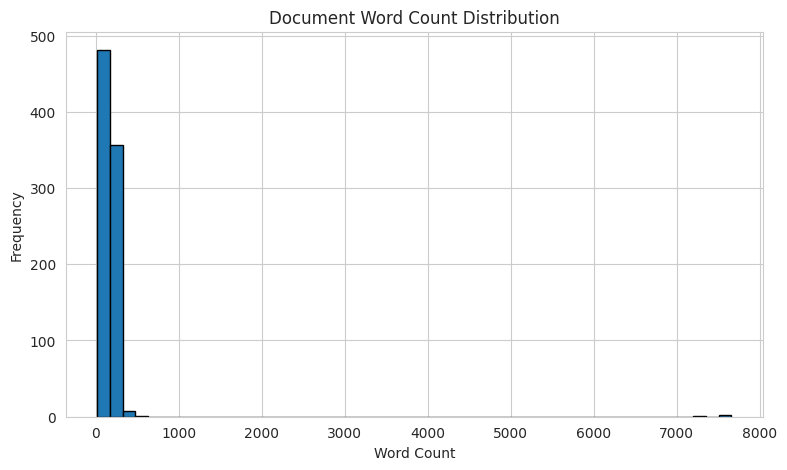


Train Size: 680, Test Size: 170

TF-IDF Shape: (680, 1985)

🔍 Evaluating best topic count...
k=4 → Error=24.918, Coherence=0.694
k=5 → Error=24.757, Coherence=0.751
k=6 → Error=24.624, Coherence=0.753
k=7 → Error=24.495, Coherence=0.763
k=8 → Error=24.362, Coherence=0.729
k=9 → Error=24.235, Coherence=0.752
k=10 → Error=24.123, Coherence=0.752
k=11 → Error=24.012, Coherence=0.713
k=12 → Error=23.914, Coherence=0.735

🏆 Optimal topic count selected: **7**

=========== FINAL TOPICS ===========

Topic 0: contract, party, contract law, agreement, promise, law, clause, term, consideration, acceptance, ucc, misrepresentation, offer, second contract, restatement second contract

Topic 1: state, constitution, court, power, united state, united, state constitution, constitutional, united state constitution, supreme, federal, amendment, law, supreme court, government

Topic 2: tort, damage, negligence, harm, duty, liability, care, plaintiff, duty care, tort law, defendant, injury, action, doctr

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


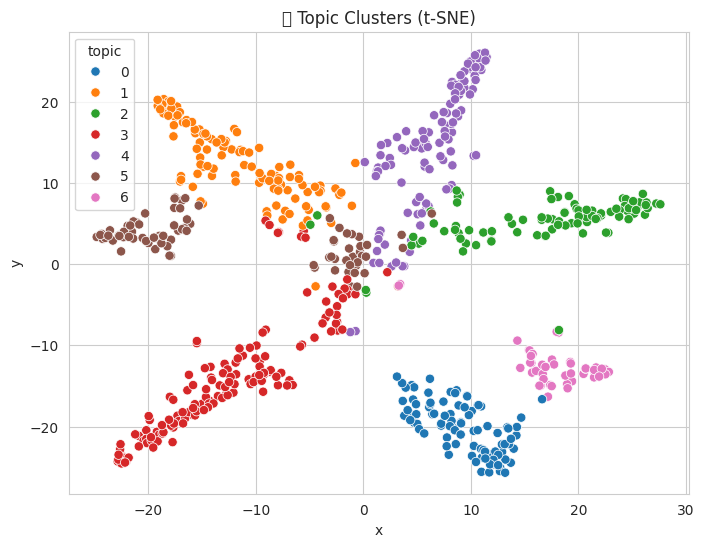


💾 Saved → topic_model_results_final.csv

📄 FINAL SUMMARY
----------------------------------
Total Documents: 680
Text Column Used: Response
Optimal Topics: 7
Silhouette Score: 0.3868
Final Coherence Score (c_v): 0.7356

Topic Distribution (%):
topic
0    13.382353
1    16.323529
2    13.823529
3    21.176471
4    16.470588
5    12.058824
6     6.764706
Name: proportion, dtype: float64


In [ ]:
# ======================================================
# 📌 Research Paper Insights - Advanced Topic Modeling (FINAL UPDATED)
# ======================================================

# ------------ STEP 1: IMPORT LIBRARIES --------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

# Topic Coherence (Ensure libraries available)
!pip install gensim nltk > /dev/null

from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary

# NLTK Setup for Lemmatization
import nltk
from nltk.stem import WordNetLemmatizer
# Downloads are assumed to be done from the user prompt
# nltk.download('wordnet')
# nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()
pd.set_option('display.max_colwidth', None)
sns.set_style("whitegrid")

# ------------ STEP 2: LOAD CSV -----------------------
file_path = "/content/rag_batch_results.csv"  # Change if needed
df = pd.read_csv(file_path)

print("📌 Dataset Loaded Successfully")
print(df.head())
print("\nColumns:", df.columns.tolist())

# ------------ STEP 3: AUTO DETECT TEXT COLUMN -------
text_cols = [c for c in df.columns if df[c].dtype == object]
best_col = max(text_cols, key=lambda c: df[c].astype(str).str.len().mean())
print(f"\n🧩 Auto-selected text column for NLP: **{best_col}**")

texts = df[best_col].astype(str).fillna("")

# ------------ STEP 4: TEXT CLEANING + LEMMATIZATION ---------
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

df["cleaned_text"] = texts.apply(clean_text)

# ------------ STEP 5: TEXT STATS ---------------------
df["word_count"] = df["cleaned_text"].apply(lambda x: len(x.split()))
print("\n📊 Word Count Summary")
print(df["word_count"].describe())

plt.figure(figsize=(9,5))
plt.hist(df["word_count"], bins=50, edgecolor='black')
plt.title("Document Word Count Distribution")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

df = df[df["word_count"] > 3].reset_index(drop=True)

# ----------- STEP 6: TRAIN SPLIT -------------
train, test = train_test_split(df, test_size=0.2, random_state=42)
print(f"\nTrain Size: {len(train)}, Test Size: {len(test)}")

# ----------- STEP 7: TF-IDF (UPDATED STOPWORDS & MIN_DF) ----------------
# Custom Stopwords to filter boilerplate words (Topic 0)
custom_stopwords = [
    'context', 'general', 'specific', 'provided', 'knowledge',
    'information', 'issue', 'authority', 'reasoning', 'conclusion',
    'legal', 'question', 'concept', 'say', 'according', 'section',
    'article', 'case', 'summary', 'nan'
]
all_stopwords = list(ENGLISH_STOP_WORDS) + custom_stopwords

tfidf = TfidfVectorizer(
    stop_words=all_stopwords,
    max_df=0.90,
    min_df=5, # Increased from 2 to 5 to filter more low-frequency noise
    ngram_range=(1, 3)
)
tfidf_matrix = tfidf.fit_transform(train["cleaned_text"])
feature_names = tfidf.get_feature_names_out()

print(f"\nTF-IDF Shape: {tfidf_matrix.shape}")

# ----------- STEP 8: TOPIC EVALUATION FUNCTION ----------
def evaluate_topics(k, tfidf_matrix, texts):
    # Note: Using the training set's cleaned_text for coherence calculation
    model = NMF(n_components=k, random_state=42, init="nndsvda", max_iter=300)
    W = model.fit_transform(tfidf_matrix)
    H = model.components_

    topic_words = []
    for topic_idx, topic in enumerate(H):
        top_indices = topic.argsort()[::-1][:10]
        topic_words.append([feature_names[i] for i in top_indices])

    dictionary = Dictionary([t.split() for t in texts])
    corpus = [dictionary.doc2bow(t.split()) for t in texts]
    coherence_model = CoherenceModel(topics=topic_words, texts=[t.split() for t in texts],
                                     dictionary=dictionary, coherence='c_v')
    coherence = coherence_model.get_coherence()

    return model.reconstruction_err_, coherence

topic_range = range(4, 13)
results = []

print("\n🔍 Evaluating best topic count...")
for k in topic_range:
    try:
        err, coh = evaluate_topics(k, tfidf_matrix, train["cleaned_text"])
        results.append((k, err, coh))
        print(f"k={k} → Error={err:.3f}, Coherence={coh:.3f}")
    except Exception as e:
        print(f"⚠ Skipped k={k}. Error: {e}")

# The optimal k is determined by the best coherence score, breaking ties with the lowest error.
optimal_k = sorted(results, key=lambda x: (-x[2], x[1]))[0][0]
print(f"\n🏆 Optimal topic count selected: **{optimal_k}**")

# ----------- STEP 9: FINAL MODEL -----------
n_topics = optimal_k
nmf = NMF(n_components=n_topics, random_state=42, init="nndsvda", max_iter=350)
nmf_W = nmf.fit_transform(tfidf_matrix)
nmf_H = nmf.components_

topics_output = []
n_top_words = 15

print("\n=========== FINAL TOPICS ===========")
for topic_idx, topic in enumerate(nmf_H):
    top_indices = topic.argsort()[::-1][:n_top_words]
    topic_terms = [(feature_names[i], round(topic[i], 4)) for i in top_indices]
    topics_output.append((topic_idx, topic_terms))
    print(f"\nTopic {topic_idx}: " + ", ".join([w for w, _ in topic_terms]))

# ----------- STEP 10: SAVE TOPIC TERMS & ASSIGN TOPICS ----------
# Save topic terms to CSV
topic_terms_df = pd.DataFrame([
    {'Topic_ID': idx, 'Terms': ", ".join([w for w, _ in terms]), 'Weights': ", ".join([str(round(w, 4)) for _, w in terms])}
    for idx, terms in topics_output
])
topic_terms_df.to_csv("nmf_topic_terms.csv", index=False)
print("\n💾 Saved → nmf_topic_terms.csv")


train["topic"] = nmf_W.argmax(axis=1)

train["topic_label"] = train["topic"].apply(
    lambda t: " | ".join([w for w, _ in topics_output[t][1][:5]])
)

print("\n📌 Sample Topic Labels:")
print(train[["topic", "topic_label"]].head())

# ------------ STEP 11: SILHOUETTE SCORE & FINAL COHERENCE -------------
sil_score = silhouette_score(nmf_W, train["topic"])

# Final Coherence Calculation (using the final model's terms)
dictionary = Dictionary([t.split() for t in train["cleaned_text"]])
final_topic_words_gensim = []
for _, terms in topics_output:
    final_topic_words_gensim.append([w for w, _ in terms])

cm_final = CoherenceModel(
    topics=final_topic_words_gensim,
    texts=[t.split() for t in train["cleaned_text"]],
    dictionary=dictionary,
    coherence='c_v'
)
final_coherence_score = cm_final.get_coherence()

print(f"\n⭐ Silhouette Score: {sil_score:.4f}")
print(f"⭐ Final Coherence Score (c_v): {final_coherence_score:.4f}")


# ------------ STEP 12: 2D VISUALIZATION -------------
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')
coords = tsne.fit_transform(nmf_W)
train["x"], train["y"] = coords[:,0], coords[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(x="x", y="y", hue="topic", data=train, palette="tab10", s=45)
plt.title("📌 Topic Clusters (t-SNE)")
plt.show()

# ------------ STEP 13: SAVE OUTPUT -------------
out_file = "topic_model_results_final.csv"
train.to_csv(out_file, index=False)
print(f"\n💾 Saved → {out_file}")

# ------------ STEP 14: FINAL SUMMARY -------------
print("\n📄 FINAL SUMMARY")
print("----------------------------------")
print(f"Total Documents: {len(train)}")
print(f"Text Column Used: {best_col}")
print(f"Optimal Topics: {n_topics}")
print(f"Silhouette Score: {sil_score:.4f}")
print(f"Final Coherence Score (c_v): {final_coherence_score:.4f}")
print("\nTopic Distribution (%):")
print(train["topic"].value_counts(normalize=True).sort_index() * 100)